In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [2]:
df_pre = pd.read_csv('../Datasets/data/pre_study_questionnaire_updated.csv', sep=",")
df = pd.read_csv('../Datasets/data/post_study_questionnaire_updated.csv', sep=",")
rg_df = pd.read_csv('../Datasets/data/field_data_field_research_group_updated.csv', sep=",")
recommendation_clicks_df = pd.read_csv('../Datasets/data/wiski_log_recommendation_clicks_updated.csv', sep=",")
quiz_result_answer_df = pd.read_csv('../Datasets/data/quiz_node_results_answers_updated.csv', sep=",")
quiz_result_df = pd.read_csv('../Datasets/data/quiz_node_results_updated.csv', sep=",")

In [3]:
df = df[df['Serienummer']>7]
df_pre = df_pre[df_pre["Serienummer"]>12]
result_df = pd.merge(df,rg_df,how='inner', left_on='UID',right_on='entity_id')
grade_df = df_pre[['UID', 'In welk leerjaar zit je?']]
result_df = pd.merge(result_df,grade_df,how='inner',left_on='UID',right_on='UID')
result_df = result_df.drop_duplicates(subset=['UID']) 
result_df = result_df[result_df['In welk leerjaar zit je?']!=" Anders"]

In [4]:
valid_uids = set(result_df['UID'].unique())
len(valid_uids)

37

In [5]:
print(len(recommendation_clicks_df))
recommendation_clicks_df = recommendation_clicks_df[recommendation_clicks_df["uid"].isin(valid_uids)]
recommendation_clicks_df.columns=recommendation_clicks_df.columns.str.strip()
print(len(recommendation_clicks_df))

737
472


In [6]:
# recommendation_clicks_df[recommendation_clicks_df['uid']==1921].dtypes
counts = dict()
valid_uids = list(valid_uids)
for uid in valid_uids:
    uid_df = recommendation_clicks_df[recommendation_clicks_df['uid']==uid]
    sorted_df = uid_df.sort_values(by=["timestamp"], axis=0)

    last_row = sorted_df.iloc[-1]
    last_click = last_row['element']
    count = counts.get(last_click, 0)
    counts[last_click] = count + 1
print(counts)

{'Button: Oefeningenoverzicht': 12, 'Button: First Recommended': 21, 'Button: Onderwerpenoverzicht': 3, 'Button: Second Recommended': 1}


In [7]:
valid_uids = list(valid_uids)
for uid in valid_uids:
    uid_df = recommendation_clicks_df[recommendation_clicks_df['uid']==uid]
    sorted_df = uid_df.sort_values(by=["timestamp"], axis=0)
    recommendation_clicks_df.drop(sorted_df.iloc[0].name,  inplace=True)

In [8]:
mapping = dict()
valid_uids = list(valid_uids)
initial_rec_click_df = pd.DataFrame(columns=recommendation_clicks_df.columns)
for uid in valid_uids:
    uid_df = recommendation_clicks_df[recommendation_clicks_df['uid']==uid]
    sorted_df = uid_df.sort_values(by=["timestamp"], axis=0)
    first_five_df = sorted_df.head(5)
    initial_rec_click_df=initial_rec_click_df.append(first_five_df)

In [9]:
initial_rec_click_df
clone = initial_rec_click_df
clone["element"].replace({"Button: Third Recommended":"3rd Recommendation","Button: First Recommended":"1st Recommendation","Button: Second Recommended":"2nd Recommendation","Button: Oefeningenoverzicht":"Not Accepted"}, inplace=True)
clone["element"].unique()

array(['3rd Recommendation', 'Not Accepted', '1st Recommendation',
       '2nd Recommendation', 'Button: Onderwerpenoverzicht'], dtype=object)

# Button Clicked Plot

Rectangle(xy=(0, -0.4), width=115, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=4, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=9, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=35, height=0.8, angle=0)


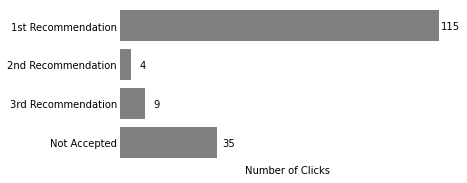

In [10]:
buttons = ["1st Recommendation", "2nd Recommendation", "3rd Recommendation", "Not Accepted"]
ax = sns.countplot(data=clone, y="element", order=buttons, color="gray")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks([])
ax.tick_params(axis='both', which='both', length=0)
for i, p in enumerate(ax.patches):
    print(p)
    width = p.get_width()
    ax.text(width + 4, p.get_y()+p.get_height()/2+0.1, p.get_width(),ha="center")
sns.despine(bottom = True, left = True)
ax.set(ylabel="", xlabel="Number of Clicks")
ax.set_aspect("14")
plt.gcf().set_facecolor('white')
plt.savefig('../Images/rec_clicks.pdf', bbox_inches='tight', format="pdf")


# Correlation Matrices

In [11]:
joined_df = pd.merge(quiz_result_df,quiz_result_answer_df,how='right', left_on='result_id',right_on='result_id')

In [12]:
joined_df = joined_df[joined_df["uid"].isin(valid_uids)]

In [13]:
rg_df = rg_df[['entity_id', 'field_research_group_value']]
df = pd.merge(rg_df,initial_rec_click_df,how='right',left_on='entity_id',right_on='uid')
df = df[df["uid"].isin(valid_uids)]

In [14]:
real_df = df[df["field_research_group_value"]==0]
placebo_df = df[df["field_research_group_value"]==1] 
nothing_df = df[df["field_research_group_value"]==2]

Find the proportion of recommendations

In [15]:
real_cut_df = real_df[['uid', 'element']]
placebo_cut_df = placebo_df[['uid', 'element']]
nothing_cut_df = nothing_df[['uid', 'element']]

In [16]:
grouped_multiple = real_cut_df.groupby(['uid', 'element']).agg({'element': ['count']})
grouped_multiple.columns = ['count']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple_2 = real_df.groupby(['uid']).agg({'element': ['count']})
grouped_multiple_2.columns = ['count_total']
grouped_multiple_2 = grouped_multiple_2.reset_index()
grouped_multiple = pd.merge(grouped_multiple, grouped_multiple_2, how="left", left_on="uid", right_on="uid")
grouped_multiple["proportion"] = grouped_multiple['count']/grouped_multiple['count_total']
grouped_multiple_real = grouped_multiple

In [17]:
grouped_multiple = placebo_cut_df.groupby(['uid', 'element']).agg({'element': ['count']})
grouped_multiple.columns = ['count']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple_2 = placebo_df.groupby(['uid']).agg({'element': ['count']})
grouped_multiple_2.columns = ['count_total']
grouped_multiple_2 = grouped_multiple_2.reset_index()
grouped_multiple = pd.merge(grouped_multiple, grouped_multiple_2, how="left", left_on="uid", right_on="uid")
grouped_multiple["proportion"] = grouped_multiple['count']/grouped_multiple['count_total']
grouped_multiple_placebo = grouped_multiple

In [18]:
grouped_multiple = nothing_cut_df.groupby(['uid', 'element']).agg({'element': ['count']})
grouped_multiple.columns = ['count']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple_2 = nothing_df.groupby(['uid']).agg({'element': ['count']})
grouped_multiple_2.columns = ['count_total']
grouped_multiple_2 = grouped_multiple_2.reset_index()
grouped_multiple = pd.merge(grouped_multiple, grouped_multiple_2, how="left", left_on="uid", right_on="uid")
grouped_multiple["proportion"] = grouped_multiple['count']/grouped_multiple['count_total']
grouped_multiple_nothing = grouped_multiple

In [19]:
grouped_multiple = grouped_multiple_real
grouped_multiple_accept_real = grouped_multiple[grouped_multiple['element']!="Not Accept"]
grouped_multiple_accept_real = grouped_multiple_accept_real.groupby(['uid']).agg({'proportion': ['sum']})
grouped_multiple_accept_real.columns = ['acceptance']
grouped_multiple_accept_real = grouped_multiple_accept_real.reset_index()
grouped_multiple_accept_real["Research Group"] = "IRE"

In [20]:
grouped_multiple = grouped_multiple_placebo
grouped_multiple_accept_placebo = grouped_multiple[grouped_multiple['element']!="Not Accept"]
grouped_multiple_accept_placebo = grouped_multiple_accept_placebo.groupby(['uid']).agg({'proportion': ['sum']})
grouped_multiple_accept_placebo.columns = ['acceptance']
grouped_multiple_accept_placebo = grouped_multiple_accept_placebo.reset_index()
grouped_multiple_accept_placebo["Research Group"] = "IPE"

In [21]:
grouped_multiple = grouped_multiple_nothing
grouped_multiple_accept_nothing = grouped_multiple[grouped_multiple['element']!="Not Accept"]
grouped_multiple_accept_nothing = grouped_multiple_accept_nothing.groupby(['uid']).agg({'proportion': ['sum']})
grouped_multiple_accept_nothing.columns = ['acceptance']
grouped_multiple_accept_nothing = grouped_multiple_accept_nothing.reset_index()
grouped_multiple_accept_nothing["Research Group"] = "INE"

In [22]:
frames = [grouped_multiple_accept_real, grouped_multiple_accept_placebo, grouped_multiple_accept_nothing]
acceptance_df = pd.concat(frames)

In [23]:
q1 = '1. Wiski is zoals een expert (bv. een leerkracht) in wiskunde-oefeningen aanraden.'
q2 = '2. Wiski heeft de expertise (kennis) om mijn wiskundeniveau te kunnen inschatten.'
q3 = '3. Wiski kan mijn wiskundeniveau inschatten.'
q4 = '4. Wiski begrijpt de moeilijkheidsgraad van wiskunde-oefeningen goed.'
q5 = '5. Wiski houdt rekening met mijn wiskundeniveau om oefeningen aan te raden.'
q6 = '6. Wiski zet op de eerste plaats dat ik vorderingen maak in wiskunde.'
q7 = '7. Wanneer Wiski oefeningen aanraadt, doet Wiski dat zodat ik vorderingen maak in wiskunde.'
q8 = '8. Wiski wilt mijn wiskundeniveau goed inschatten.'
q9 = '9. Wiski raadt oefeningen op een zo correct mogelijke manier aan.'
q10 = '10. Wiski is eerlijk.'
q11 = '11. Wiski maakt oprechte aanbevelingen.'
q12 = '12. Ik vertrouw Wiski om mij wiskunde-oefeningen aan te raden.'
q13 = '13. Als ik nog eens online wiskunde-oefeningen maak, dan kies ik voor Wiski.'
q14 = '14. Als ik nog eens wiskunde-oefeningen aangeraden wil krijgen, dan kies ik voor Wiski.'
q15 = '15. Ik vind dat Wiski genoeg uitleg geeft over waarom een oefening aangeraden is.'
q16 = '16. Wanneer ik Wiski gebruik, wil ik GEEN uitleg over waarom een oefening wordt aangeraden.'
q17 = '17. Ik vind uitleg krijgen over waarom een oefening wordt aangeraden belangrijker dan waarom een film wordt aangeraden.'
q18 = '18. Ik ben NIET blij met het niveau van de oefeningen die Wiski aanraadde.'
q19 = '19. In het algemeen vind ik het belangrijk om uitleg te krijgen wanneer iets (oefening/film/product/...) wordt aangeraden.'


def map_likert_to_int(key):
    if key == "Helemaal oneens":
        return 1
    elif key == "Oneens":
        return 2
    elif key == "Eerder oneens":
        return 3
    elif key == "Neutraal":
        return 4
    elif key == "Eerder eens":
        return 5
    elif key == "Eens":
        return 6
    elif key == "Helemaal eens":
        return 7
def dic_scores_competence(df):
    scores = dict()
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0
        score += int(map_likert_to_int(row[q1].strip()))
        score += int(map_likert_to_int(row[q2].strip()))
        score += int(map_likert_to_int(row[q3].strip()))
        score += int(map_likert_to_int(row[q4].strip()))
        score += int(map_likert_to_int(row[q5].strip()))
        scores[row['UID']] = score/5
    return scores
def dic_scores_benevolence(df):
    scores = dict()
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0
        score += int(map_likert_to_int(row[q6].strip()))
        score += int(map_likert_to_int(row[q7].strip()))
        score += int(map_likert_to_int(row[q8].strip()))
        scores[row['UID']] = score/3
    return scores
def dic_scores_integrity(df):
    scores = dict()
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0
        score += int(map_likert_to_int(row[q9].strip()))
        score += int(map_likert_to_int(row[q10].strip()))
        score += int(map_likert_to_int(row[q11].strip()))
        scores[row['UID']] = score/3
    return scores       
def dic_scores_trusting_beliefs(competence, benevolence, integrity):
    scores = dict()
    for pair in competence.items():
        uid = pair[0]
        scores[uid] = competence[uid]+benevolence[uid]+integrity[uid]
    return scores
def dic_scores_perceived_transparency(df):
    scores = dict()
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0
        score += int(map_likert_to_int(row[q15].strip()))
        scores[row['UID']] = score
    return scores
def dic_scores_intention_to_return(df):
    scores = dict()
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0
        score += int(map_likert_to_int(row[q13].strip()))
        score += int(map_likert_to_int(row[q14].strip()))
        scores[row['UID']] = score/2
    return scores
def dic_scores_single_q(df, q_number):
    scores = dict()
    for i in range(len(df)):
        row = df.iloc[i]
        score = 0
        score += int(map_likert_to_int(row[q_number].strip()))
        scores[row['UID']] = score
    return scores
def dic_scores_md_trust(trusting_beliefs, intention_to_return, perceived_transparency):
    scores = dict()
    for pair in trusting_beliefs.items():
        uid = pair[0]
        scores[uid] = trusting_beliefs[uid] + intention_to_return[uid] + perceived_transparency[uid]
    return scores
def dic_scores_md_trust_reweighted(trusting_beliefs, intention_to_return, perceived_transparency):
    scores = dict()
    for pair in trusting_beliefs.items():
        uid = pair[0]
        scores[uid] = (trusting_beliefs[uid]/3 + intention_to_return[uid] + perceived_transparency[uid])/3
    return scores

In [24]:
result_df = pd.merge(result_df,rg_df,how='inner', left_on='UID',right_on='entity_id')
result_df = result_df.rename(columns={'field_research_group_value_x': 'field_research_group_value'})

In [25]:
result_real_df = result_df[result_df["field_research_group_value"]==0]
result_placebo_df = result_df[result_df["field_research_group_value"]==1]
result_nothing_df = result_df[result_df["field_research_group_value"]==2]


In [26]:
competence_scores_real = dic_scores_competence(result_real_df)
competence_scores_placebo = dic_scores_competence(result_placebo_df)
competence_scores_nothing = dic_scores_competence(result_nothing_df)
competence_scores = dict(competence_scores_real)
competence_scores.update(competence_scores_placebo)
competence_scores.update(competence_scores_nothing)
competence_df = pd.DataFrame.from_dict(competence_scores, orient="index", columns=["Competence"]).reset_index()
competence_df.columns = ["uid", "Competence"]

benevolence_scores_real = dic_scores_benevolence(result_real_df)
benevolence_scores_placebo = dic_scores_benevolence(result_placebo_df)
benevolence_scores_nothing = dic_scores_benevolence(result_nothing_df)
benevolence_scores = dict(benevolence_scores_real)
benevolence_scores.update(benevolence_scores_placebo)
benevolence_scores.update(benevolence_scores_nothing)
benevolence_df = pd.DataFrame.from_dict(benevolence_scores, orient="index").reset_index()
benevolence_df.columns = ["uid", "Benevolence"]


integrity_scores_real = dic_scores_integrity(result_real_df)
integrity_scores_placebo = dic_scores_integrity(result_placebo_df)
integrity_scores_nothing = dic_scores_integrity(result_nothing_df)
integrity_scores = dict(integrity_scores_real)
integrity_scores.update(integrity_scores_placebo)
integrity_scores.update(integrity_scores_nothing)
integrity_df = pd.DataFrame.from_dict(integrity_scores, orient="index").reset_index()
integrity_df.columns = ["uid", "Integrity"]



trusting_beliefs_scores_real = dic_scores_trusting_beliefs(competence_scores_real, benevolence_scores_real, integrity_scores_real)
trusting_beliefs_scores_placebo = dic_scores_trusting_beliefs(competence_scores_placebo, benevolence_scores_placebo, integrity_scores_placebo)
trusting_beliefs_scores_nothing = dic_scores_trusting_beliefs(competence_scores_nothing, benevolence_scores_nothing, integrity_scores_nothing)
trusting_beliefs_scores = dict(trusting_beliefs_scores_real)
trusting_beliefs_scores.update(trusting_beliefs_scores_placebo)
trusting_beliefs_scores.update(trusting_beliefs_scores_nothing)
trusting_beliefs_df = pd.DataFrame.from_dict(trusting_beliefs_scores, orient="index").reset_index()
trusting_beliefs_df.columns = ["uid", "Trusting Beliefs"]



itr_scores_real = dic_scores_intention_to_return(result_real_df)
itr_scores_placebo = dic_scores_intention_to_return(result_placebo_df)
itr_scores_nothing = dic_scores_intention_to_return(result_nothing_df)
itr_scores = dict(itr_scores_real)
itr_scores.update(itr_scores_placebo)
itr_scores.update(itr_scores_nothing)
itr_df = pd.DataFrame.from_dict(itr_scores, orient="index").reset_index()
itr_df.columns = ["uid", "Intention to Return"]

pt_scores_real = dic_scores_perceived_transparency(result_real_df)
pt_scores_placebo = dic_scores_perceived_transparency(result_placebo_df)
pt_scores_nothing = dic_scores_perceived_transparency(result_nothing_df)
pt_scores = dict(pt_scores_real)
pt_scores.update(pt_scores_placebo)
pt_scores.update(pt_scores_nothing)
pt_df = pd.DataFrame.from_dict(pt_scores, orient="index").reset_index()
pt_df.columns = ["uid", "Perceived Transparency"]


explicit_trust_scores_real = dic_scores_single_q(result_real_df, q12)
explicit_trust_scores_placebo = dic_scores_single_q(result_placebo_df, q12)
explicit_trust_scores_nothing = dic_scores_single_q(result_nothing_df, q12)
explicit_trust_scores = dict(explicit_trust_scores_real)
explicit_trust_scores.update(explicit_trust_scores_placebo)
explicit_trust_scores.update(explicit_trust_scores_nothing)
explicit_trust_df = pd.DataFrame.from_dict(explicit_trust_scores, orient="index").reset_index()
explicit_trust_df.columns = ["uid", "1D Trust"]

md_trust_scores_real = dic_scores_md_trust(trusting_beliefs_scores_real, itr_scores_real, pt_scores_real)
md_trust_scores_placebo = dic_scores_md_trust(trusting_beliefs_scores_placebo, itr_scores_placebo, pt_scores_placebo)
md_trust_scores_nothing = dic_scores_md_trust(trusting_beliefs_scores_nothing, itr_scores_nothing, pt_scores_nothing)
md_trust_scores = dict(md_trust_scores_real)
md_trust_scores.update(md_trust_scores_placebo)
md_trust_scores.update(md_trust_scores_nothing)
md_trust_df = pd.DataFrame.from_dict(md_trust_scores, orient="index").reset_index()
md_trust_df.columns = ["uid", "MD Trust"]


rw_md_trust_scores_real = dic_scores_md_trust_reweighted(trusting_beliefs_scores_real, itr_scores_real, pt_scores_real)
rw_md_trust_scores_placebo = dic_scores_md_trust_reweighted(trusting_beliefs_scores_placebo, itr_scores_placebo, pt_scores_placebo)
rw_md_trust_scores_nothing = dic_scores_md_trust_reweighted(trusting_beliefs_scores_nothing, itr_scores_nothing, pt_scores_nothing)
rw_md_trust_scores = dict(rw_md_trust_scores_real)
rw_md_trust_scores.update(rw_md_trust_scores_placebo)
rw_md_trust_scores.update(rw_md_trust_scores_nothing)
rw_md_trust_df = pd.DataFrame.from_dict(rw_md_trust_scores, orient="index").reset_index()
rw_md_trust_df.columns = ["uid", "MD Trust (RW)"]

In [27]:
response_df = pd.merge(competence_df, benevolence_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, integrity_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, trusting_beliefs_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, itr_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, pt_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, explicit_trust_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, md_trust_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, rw_md_trust_df, how="inner", left_on="uid", right_on="uid")

In [28]:
master_df = pd.merge(response_df, acceptance_df, how="inner", left_on="uid", right_on="uid")

In [29]:
master_df.columns = ["uid","Competence", "Benevolence", "Integrity", "Trusting Beliefs", "Intention to Return", "Perceived Transparency", "1D Trust", "MD Trust", "MD Trust (RW)", "Acceptance", "Research Group"]

In [30]:
correlation_matrix = master_df[["Competence", "Benevolence", "Integrity", "Trusting Beliefs", "Intention to Return", "Perceived Transparency", "1D Trust", "MD Trust", "MD Trust (RW)"]].corr(method="kendall")
round(correlation_matrix,2)

,Competence,Benevolence,Integrity,Trusting Beliefs,Intention to Return,Perceived Transparency,1D Trust,MD Trust,MD Trust (RW)
Competence,1.00,0.43,0.65,0.78,0.52,0.17,0.69,0.69,0.58
Benevolence,0.43,1.00,0.39,0.61,0.41,0.06,0.40,0.51,0.38
Integrity,0.65,0.39,1.00,0.74,0.39,0.10,0.71,0.60,0.45
Trusting Beliefs,0.78,0.61,0.74,1.00,0.53,0.14,0.68,0.73,0.56
Intention to Return,0.52,0.41,0.39,0.53,1.00,0.04,0.52,0.56,0.51
Perceived Transparency,0.17,0.06,0.10,0.14,0.04,1.00,0.17,0.41,0.58
1D Trust,0.69,0.40,0.71,0.68,0.52,0.17,1.00,0.63,0.52
MD Trust,0.69,0.51,0.60,0.73,0.56,0.41,0.63,1.00,0.83
MD Trust (RW),0.58,0.38,0.45,0.56,0.51,0.58,0.52,0.83,1.00


In [31]:
construct_corr = correlation_matrix.loc[["Competence", "Benevolence", "Integrity", "Intention to Return", "Perceived Transparency", "1D Trust"],["Competence", "Benevolence", "Integrity", "Intention to Return", "Perceived Transparency", "1D Trust"]]

In [32]:
def make_heatmap(data, path):
    data_round = round(data,2)
    ax = sns.heatmap(data_round, annot=True, cmap=sns.color_palette("RdBu_r", as_cmap=True), vmin=-1, vmax=1, square=True)
    ax.tick_params(axis='both', which='both', length=0)
    plt.yticks(rotation=0)
    plt.gcf().set_facecolor('white')
    plt.savefig(path, bbox_inches="tight", format="pdf")

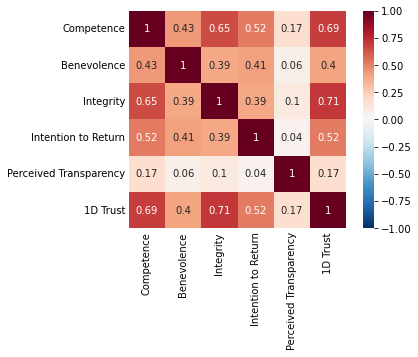

In [33]:
make_heatmap(construct_corr, "../Images/corr_trustconstructs.pdf")


In [34]:
q16_scores_real = dic_scores_single_q(result_real_df, q16)
q16_scores_placebo = dic_scores_single_q(result_placebo_df, q16)
q16_scores_nothing = dic_scores_single_q(result_nothing_df, q16)
q16_scores = dict(q16_scores_real)
q16_scores.update(q16_scores_placebo)
q16_scores.update(q16_scores_nothing)
q16_df = pd.DataFrame.from_dict(q16_scores, orient="index").reset_index()
q16_df.columns = ["uid", "Q16"]


q17_scores_real = dic_scores_single_q(result_real_df, q17)
q17_scores_placebo = dic_scores_single_q(result_placebo_df, q17)
q17_scores_nothing = dic_scores_single_q(result_nothing_df, q17)
q17_scores = dict(q17_scores_real)
q17_scores.update(q17_scores_placebo)
q17_scores.update(q17_scores_nothing)
q17_df = pd.DataFrame.from_dict(q17_scores, orient="index").reset_index()
q17_df.columns = ["uid", "Q17"]


q18_scores_real = dic_scores_single_q(result_real_df, q18)
q18_scores_placebo = dic_scores_single_q(result_placebo_df, q18)
q18_scores_nothing = dic_scores_single_q(result_nothing_df, q18)
q18_scores = [q18_scores_real, q18_scores_placebo, q18_scores_nothing]
q18_scores = dict(q18_scores_real)
q18_scores.update(q18_scores_placebo)
q18_scores.update(q18_scores_nothing)
q18_df = pd.DataFrame.from_dict(q18_scores, orient="index").reset_index()
q18_df.columns = ["uid", "Q18"]

q19_scores_real = dic_scores_single_q(result_real_df, q19)
q19_scores_placebo = dic_scores_single_q(result_placebo_df, q19)
q19_scores_nothing = dic_scores_single_q(result_nothing_df, q19)
q19_scores = [q19_scores_real, q19_scores_placebo, q19_scores_nothing]
q19_scores = dict(q19_scores_real)
q19_scores.update(q19_scores_placebo)
q19_scores.update(q19_scores_nothing)
q19_df = pd.DataFrame.from_dict(q19_scores, orient="index").reset_index()
q19_df.columns = ["uid", "Q19"]

In [35]:
response_df = pd.merge(response_df, q16_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, q17_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, q18_df, how="inner", left_on="uid", right_on="uid")
response_df = pd.merge(response_df, q19_df, how="inner", left_on="uid", right_on="uid")

In [36]:
trust_correlation_matrix_augmented = response_df[["Competence", "Benevolence", "Integrity", "Trusting Beliefs", "Intention to Return", "Perceived Transparency", "1D Trust", "MD Trust",  "Q16", "Q17", "Q18", "Q19"]].corr(method="kendall")
trust_correlation_matrix_augmented.at['Trusting Beliefs', 'MD Trust'] = correlation_matrix.loc['Trusting Beliefs', 'MD Trust (RW)'] 
trust_correlation_matrix_augmented.at['MD Trust', 'Trusting Beliefs'] = correlation_matrix.loc['Trusting Beliefs', 'MD Trust (RW)'] 
tail_matrix = trust_correlation_matrix_augmented.tail(4).iloc[:,:]

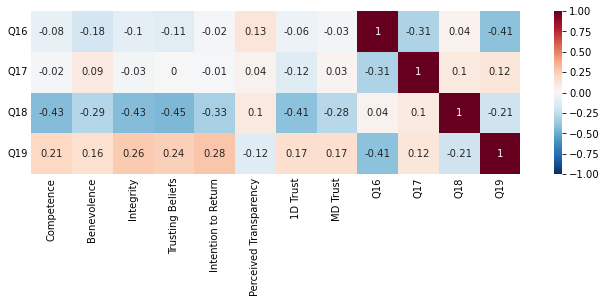

In [37]:
plt.figure(figsize = (12,3))
make_heatmap(tail_matrix, "../Images/corr_extraquestions.pdf")